In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from multiprocess import Pool
import pickle
from enum import Enum

In [2]:
#make observer

In [3]:
class Genome:
        
    def __init__(self, seed, length=10000, cohesin_stopper_gap=5, condensin_stopper_gap=100):
        np.random.default_rng(seed)
        cohesin_stopper_p = 1/cohesin_stopper_gap
        condensin_stopper_p = 1/condensin_stopper_gap
        no_stopper_p = 1 - cohesin_stopper_p - condensin_stopper_p
        self.array = np.random.choice([0, 1, 2], 
                                      size=length, 
                                      p=[no_stopper_p, 
                                         cohesin_stopper_p, 
                                         condensin_stopper_p])
        self.occupited = np.zeros(length, dtype=bool)
        
    def get_length(self):
        return len(self.array)
        
    def get_array(self):
        return self.array
    
    def is_occupited(self, index):
        return self.occupited[index]
    
    def update_occupited(self, index, status=True):
        self.occupited[index] = status
        
    def __str__(self):
        return str(self.array)
            
        

In [4]:
genome = Genome(1)
print(genome)

[0 1 0 ... 0 0 2]


In [5]:
class Extruder:
    
    def __init__(self, stalling_prob, dissociation_prob):
        self.stalling_prob = stalling_prob
        self.dissociation_prob = dissociation_prob
        
        self.active = True
        self.left = True
        self.right = True
        self.bind = False
        
        self.current_left = None
        self.current_right = None
        
    def set_direction(self, index, direction):
        if self.left and direction == "left":
            self.current_left = index
        elif self.right and direction == "right":
            self.current_right = index

    def set_direction_status(self, boolean, direction):
        if direction == "left":
            self.left = boolean
        elif direction == "right":
            self.right = boolean
        self.is_active()
        
    def get_direction_status(self, direction):
        if direction == "left":
            return self.left
        elif direction == "right":
            return self.right
        
    def is_active(self):
        self.active = (self.left or self.right)
        return self.active
        
    def is_bind(self):
        return self.bind
    
    def bound(self):
        self.bind = True
        
    def get_position(self):
        return self.current_left, self.current_right
    
    def reset(self):
        self.active = True
        self.left = True
        self.right = True
        self.bind = False
        
        self.current_left = None
        self.current_right = None
    

In [6]:
class Cohesin(Extruder):
    
    def name(self):
        return "Cohesin"
    
    def stop_i(self):
        return 1
    
    def color(self):
        return "b"
    
    def __str__(self):
        return f"Cohesin at {self.get_position()}"

In [7]:
class Condensin(Extruder):
    
    def name(self):
        return "Condensin"
    
    def stop_i(self):
        return 2
    
    def color(self):
        return "r"
    
    def __str__(self):
        return f"Condensin at {self.get_position()}"

In [8]:
class ExtruderType(Enum):
    COHESIN = 1
    CONDENSIN = 2

In [9]:
class ExtruderFactory:
    
    def get(e_type, stalling_prob=1,  dissociation_prob=1):
        
        return {
            ExtruderType.COHESIN: Cohesin(stalling_prob, dissociation_prob),
            ExtruderType.CONDENSIN: Condensin(stalling_prob, dissociation_prob)
        }.get(e_type,0)

In [10]:
class Simulator:
    
    def __init__(self, genome, seed, n_extruders=1000, per_i=10, option="cohesin"): 
        np.random.seed(seed)
        self.genome = genome
        self.genome_length = genome.get_length()
        self.extruder_factory = ExtruderFactory
        self.extruders = self._check_option(n_extruders, option)
        self.extruders_per_i = int(n_extruders/per_i)
        self.bound = np.zeros(self.genome_length, dtype=bool)
        self.unbound = np.zeros(self.genome_length, dtype=bool)
        self.n_bound = list()
        self.n_active = list()
        self.time = 0
        
    def simulate(self, time):
        self.time += time
        for i in range(time):
            self._simulate_one_step(i)
            self.n_bound.append(np.sum(self.bound))
            self.n_active.append(np.sum([e.is_active() for e in self.extruders]))
    
    def plot(self):
        ts = np.arange(self.time)
        plt.plot(ts, self.n_bound, label="bound")
        plt.plot(ts, self.n_active, label="active")
    
    def plot_fold(self, i=None):
        if i is None:
            for j, e in enumerate(self.extruders):
                start, end = e.get_position()
                if start != None and end != None:
                    xs = np.linspace(start,end)
                    ys = np.full(len(xs), j)
                    plt.plot(xs, ys, c = e.color())
        else:
            for j, e in enumerate(self.extruders):
                start, end = e.get_position()
                if start != None and end != None:
                    xs = np.linspace(start,end)
                    ys = np.full(len(xs), i)
                    plt.plot(xs, ys, c = e.color())
    
    def average_domain(self):
        extruders_domains = dict()
        extruders_mean = dict()
        for e in self.extruders:
            start, end = e.get_position()
            if start != None and end != None:
                domain = end - start
                if extruders_domains.get(e.name()) is None:
                    extruders_domains[e.name()] = [domain]
                else:
                    extruders_domains[e.name()].append(domain)
        for key in extruders_domains:
            extruders_mean[key] = np.mean(extruders_domains[key])
        labels, data = [*zip(*extruders_domains.items())]
        plt.boxplot(data)
        plt.xticks(range(1, len(labels) + 1), labels)
        return extruders_mean  
        
    def _simulate_one_step(self, i):
        if i*self.extruders_per_i < len(self.extruders):
            start_sites = self._get_start_sites(self.extruders_per_i)
            for site, index in enumerate(range(i*self.extruders_per_i, (i+1)*self.extruders_per_i)):
                l_site = start_sites[site]
                if index >= len(self.extruders):
                    break
                self._sim_one_helper(l_site, index, False)
        self._dissociate()
        start_sites = self._get_start_sites(np.sum(self.unbound))
        try:
            current_unbound = np.nditer(np.where(self.unbound))
            for site, index in enumerate(current_unbound):
                l_site = start_sites[site]
                self._sim_one_helper(l_site, index, True)   
        except ValueError:
            pass
        self._extrude()
        
    def _sim_one_helper(self, l_site, index, second):
        r_site = l_site + 1
        extruder = self.extruders[index]
        if not (self.genome.is_occupited(l_site) or self.genome.is_occupited(r_site)):
            extruder.set_direction(l_site, "left")
            extruder.set_direction(r_site, "right")
            self.genome.update_occupited(l_site)
            self.genome.update_occupited(r_site)
            extruder.bound()
            self.bound[index] = True
            if second:
                self.unbound[index] = False
            return None
        if not second:
            self.unbound[index] = True
        
    def _extrude(self):
        try:
            for i in np.nditer(np.where(self.bound)):
                extruder = self.extruders[i]
                left, right = extruder.get_position()
                n_left = left-1
                n_right = right+1
                if n_left < 0:
                    extruder.set_direction_status(False, "left")
                if n_right >= self.genome_length:
                    extruder.set_direction_status(False, "right")
                if extruder.get_direction_status("left"):
                    self._set_direction(extruder, left, n_left, "left")
                if extruder.get_direction_status("right"):
                    self._set_direction(extruder, right, n_right, "right")
        except ValueError:
            pass
        
    def _dissociate(self):
        try:
            for i in np.nditer(np.where(self.bound)):
                dissociation_prob = np.random.random()
                extruder = self.extruders[i]
                l_site, r_site = extruder.get_position()
                if extruder.dissociation_prob < dissociation_prob:
                    self.genome.update_occupited(l_site, False)
                    self.genome.update_occupited(r_site, False)
                    extruder.reset()
                    self.unbound[i] = True
                    self.bound[i] = False
        except ValueError:
            pass
    
    def _set_direction(self, extruder, current, i, direction):
        if not self.genome.is_occupited(i):
            stalling_prob = np.random.random()
            extruder.set_direction(i, direction)
            self.genome.update_occupited(i, True)
            self.genome.update_occupited(current, False)
            if (self.genome.array[i] == extruder.stop_i()) and (extruder.stalling_prob > stalling_prob):
                extruder.set_direction_status(False, direction)
        elif self.genome.is_occupited(i):
            extruder.set_direction_status(False, direction)
                                     
                            
    def _check_option(self, n_extruder, option):
        choices = {
            "cohesin" : [self.extruder_factory.get(ExtruderType.COHESIN) for i in range(int(n_extruder))],
            "both" : [self.extruder_factory.get(ExtruderType.COHESIN) for i in range(int(n_extruder//2))],
            "both_0.2" : [self.extruder_factory.get(ExtruderType.COHESIN, stalling_prob=0.2) for i in range(int(n_extruder//2))],
            "both_d_0.5" : [self.extruder_factory.get(ExtruderType.COHESIN, stalling_prob=1, dissociation_prob=0.5) for i in range(int(n_extruder//2))]
        } 
        
        choices["both"].extend([self.extruder_factory.get(ExtruderType.CONDENSIN) for i in range(int(n_extruder//2))])
        choices["both_0.2"].extend([self.extruder_factory.get(ExtruderType.CONDENSIN,stalling_prob=0.2) for i in range(int(n_extruder//2))])
        choices["both_d_0.5"].extend([self.extruder_factory.get(ExtruderType.CONDENSIN, stalling_prob=1, dissociation_prob=0.5) for i in range(int(n_extruder//2))])
        np.random.shuffle(choices[option])
        return choices[option]
        
    def _get_start_sites(self,extruders_per_i):
        return np.random.randint(0, self.genome_length-2, extruders_per_i)
          
    

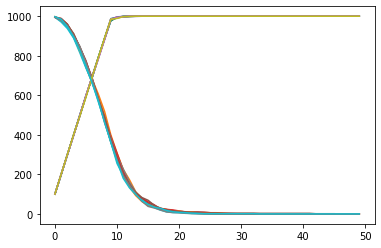

In [11]:
for i in range(10):
    sim = Simulator(Genome(1),i)
    sim.simulate(50)
    sim.plot()
# plt.legend()
plt.show()

1000
0
0


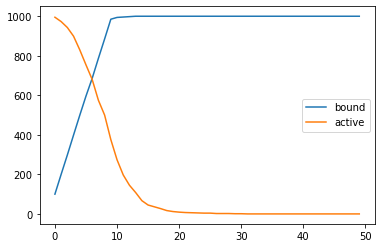

In [12]:
sim = Simulator(Genome(1),1)
sim.simulate(50)
sim.plot()
print(sim.n_bound[-1])
print(sim.n_active[-1])
print(sum(sim.unbound))
plt.legend()
plt.show()

1000
0
0


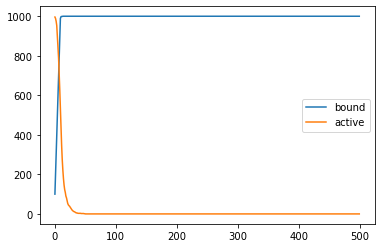

{'Condensin': 12.956, 'Cohesin': 6.964}


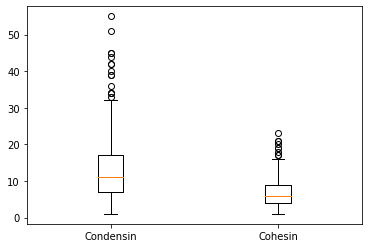

2000
0
0


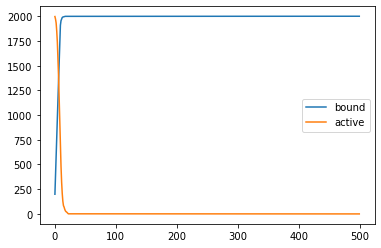

{'Cohesin': 5.329, 'Condensin': 7.167}


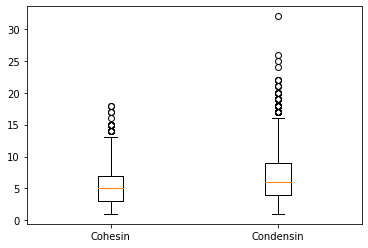

3000
0
0


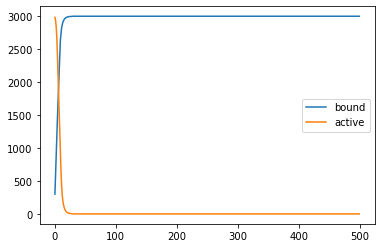

{'Condensin': 5.213333333333333, 'Cohesin': 4.148666666666666}


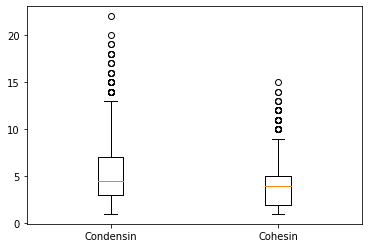

4000
0
0


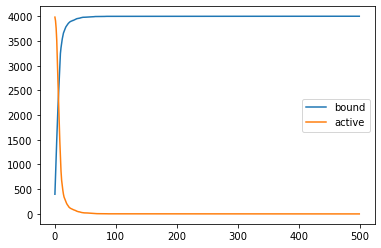

{'Cohesin': 3.5305, 'Condensin': 4.0045}


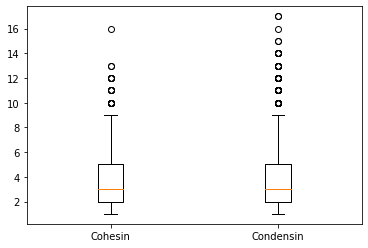

4469
531
531


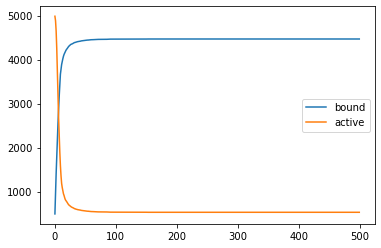

{'Condensin': 3.4769780956638354, 'Cohesin': 3.0667562724014337}


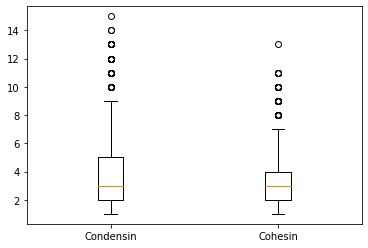

4460
1540
1540


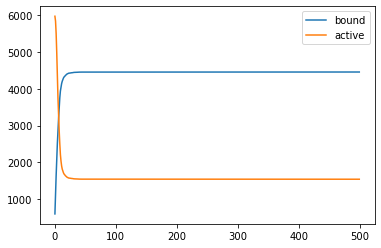

{'Cohesin': 2.978308986277114, 'Condensin': 3.286687869150386}


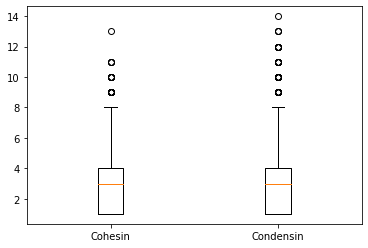

4438
2562
2562


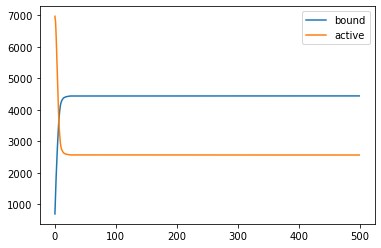

{'Cohesin': 2.829968595782862, 'Condensin': 3.2055228610230873}


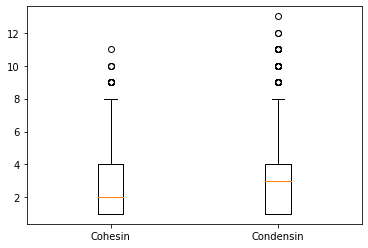

4438
3562
3562


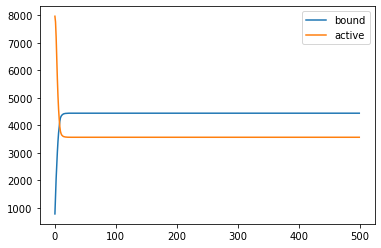

{'Condensin': 3.125, 'Cohesin': 2.744824482448245}


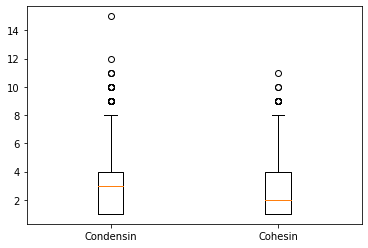

4430
4570
4570


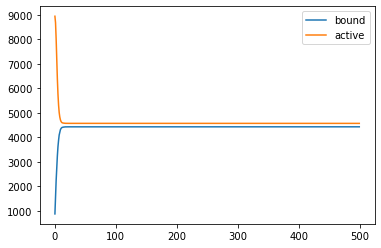

{'Condensin': 2.952468007312614, 'Cohesin': 2.7363960749330953}


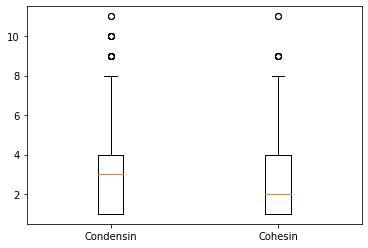

4412
5588
5588


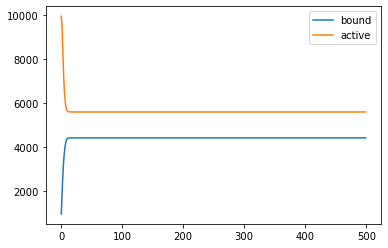

{'Condensin': 2.797107998192499, 'Cohesin': 2.6934970441109596}


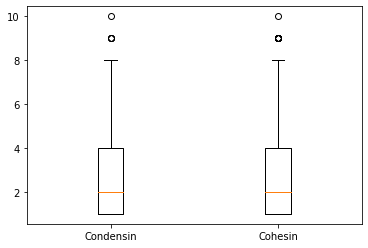

In [13]:
for i in range(1,11):    
    sim = Simulator(Genome(1),1, n_extruders=i*1000, option="both")
    sim.simulate(500)
    sim.plot()
    print(sim.n_bound[-1])
    print(sim.n_active[-1])
    print(sum(sim.unbound))
    plt.legend()
    plt.show()
    print(sim.average_domain())
    plt.show()

881
826
119


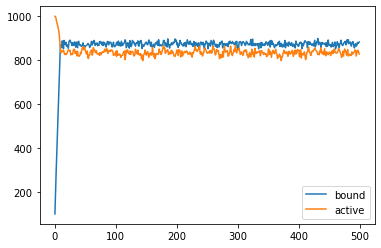

{'Condensin': 3.853982300884956, 'Cohesin': 3.582750582750583}


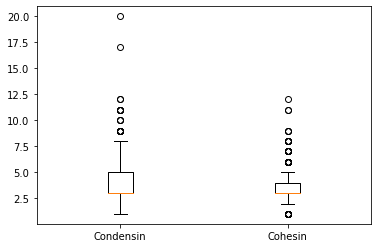

1541
1540
459


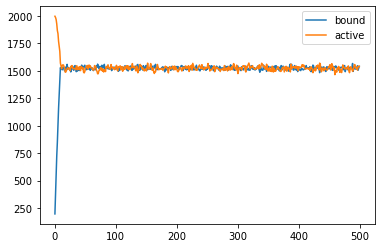

{'Cohesin': 3.035479632063075, 'Condensin': 3.2115384615384617}


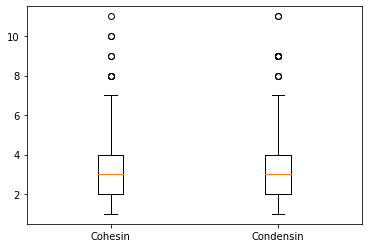

2018
2181
982


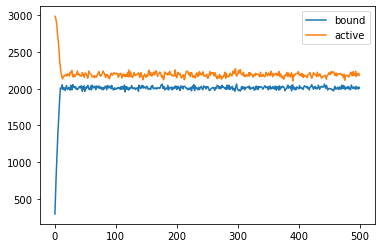

{'Condensin': 2.8598039215686275, 'Cohesin': 2.8046092184368736}


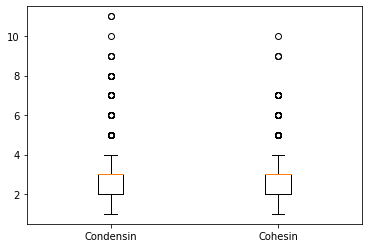

2384
2857
1616


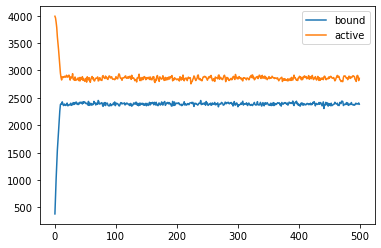

{'Cohesin': 2.47840260798696, 'Condensin': 2.537597234226448}


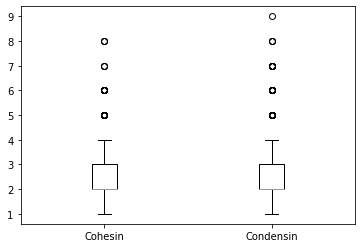

2677
3527
2323


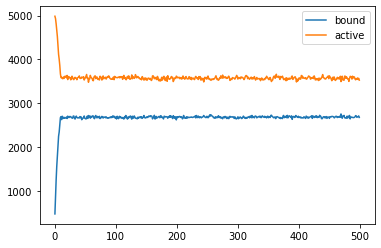

{'Condensin': 2.3425995492111196, 'Cohesin': 2.2860326894502228}


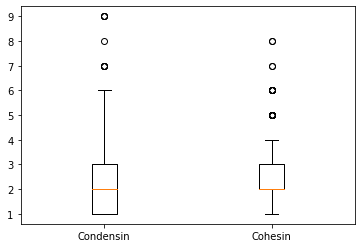

2886
4352
3114


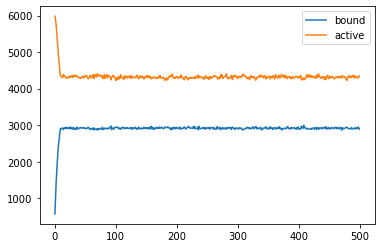

{'Cohesin': 2.187853107344633, 'Condensin': 2.202721088435374}


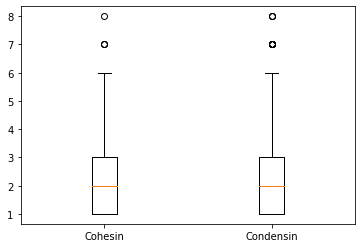

3136
5042
3864


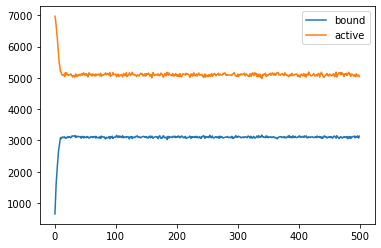

{'Cohesin': 2.0433673469387754, 'Condensin': 2.0631377551020407}


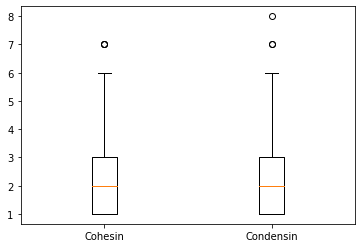

3245
5914
4755


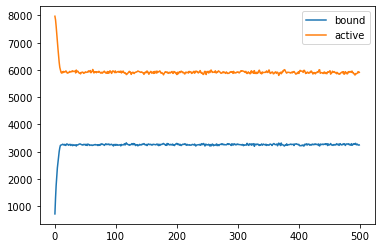

{'Condensin': 1.9844816883923029, 'Cohesin': 1.9357405140758874}


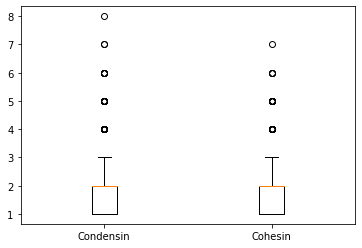

3378
6744
5622


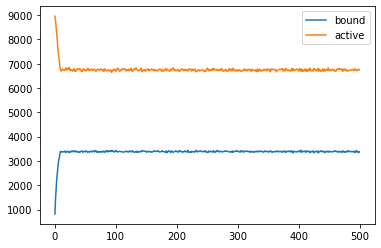

{'Condensin': 1.896987951807229, 'Cohesin': 1.869033760186263}


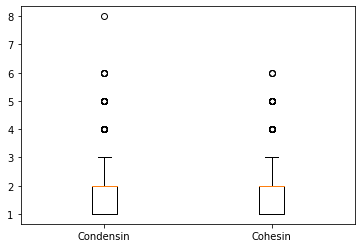

3508
7554
6492


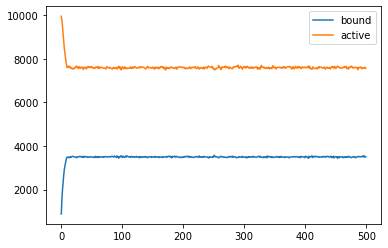

{'Cohesin': 1.8080407701019252, 'Condensin': 1.80654420206659}


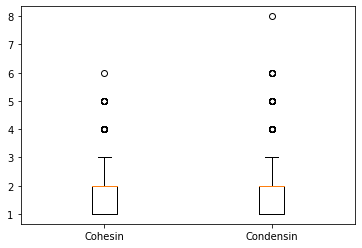

In [14]:
for i in range(1,11):    
    sim = Simulator(Genome(1),1, n_extruders=i*1000, option="both_d_0.5")
    sim.simulate(500)
    sim.plot()
    print(sim.n_bound[-1])
    print(sim.n_active[-1])
    print(sum(sim.unbound))
    plt.legend()
    plt.show()
    print(sim.average_domain())
    plt.show()

100
30
0


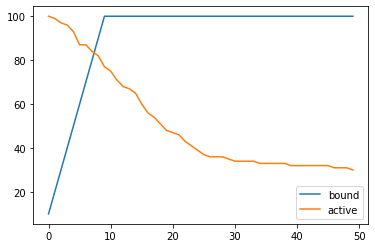

{'Condensin': 55.32, 'Cohesin': 10.94}


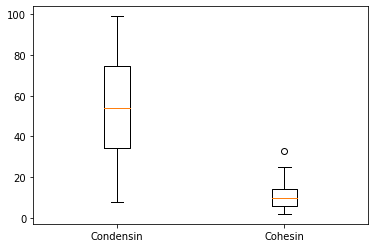

In [15]:
np.random.seed(27)
sim = Simulator(Genome(1),1, n_extruders=100, option="both")
sim.simulate(50)
sim.plot()
print(sim.n_bound[-1])
print(sim.n_active[-1])
print(sum(sim.unbound))
plt.legend()
plt.show()
print(sim.average_domain())
plt.show()

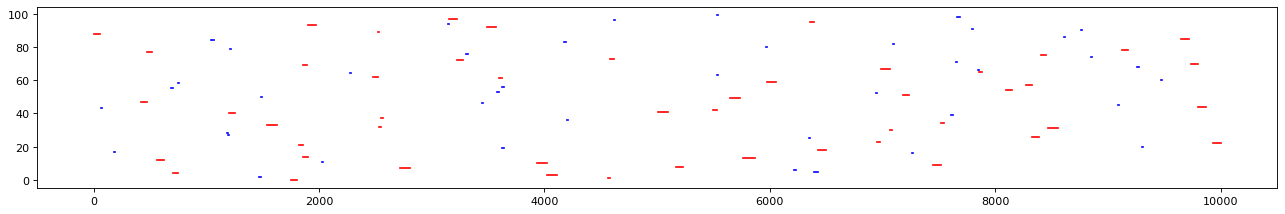

In [16]:
plt.figure(figsize=(20, 3), dpi=80)
sim.plot_fold()

100
43
0


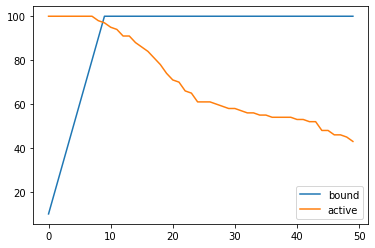

{'Condensin': 63.08, 'Cohesin': 31.28}


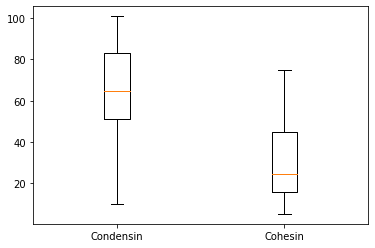

In [17]:
np.random.seed(27)
sim = Simulator(Genome(1),1, n_extruders=100, option="both_0.2")
sim.simulate(50)
sim.plot()
print(sim.n_bound[-1])
print(sim.n_active[-1])
print(sum(sim.unbound))
plt.legend()
plt.show()
print(sim.average_domain())
plt.show()

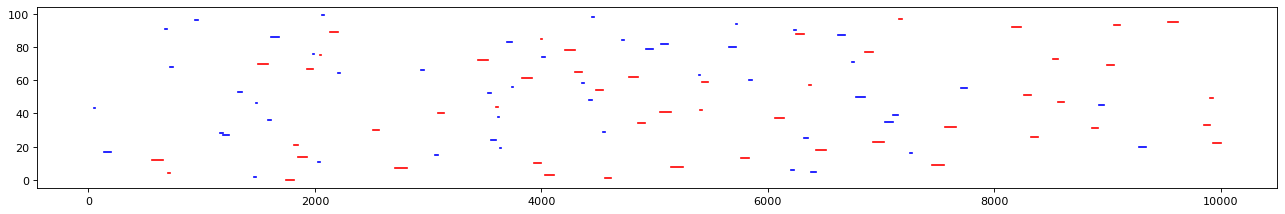

In [18]:
plt.figure(figsize=(20, 3), dpi=80)
sim.plot_fold()

1
0
0


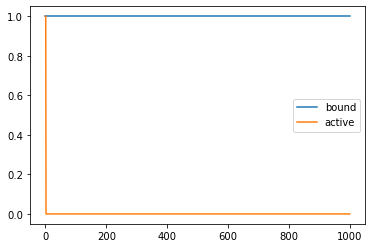

{'Cohesin': 6.0}


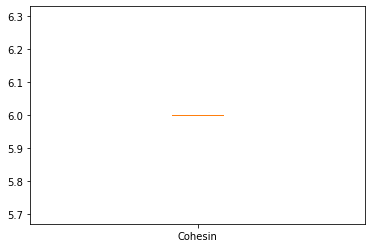

In [19]:
np.random.seed(27)
sim = Simulator(Genome(1),1, n_extruders=1, per_i=1)
sim.simulate(1000)
sim.plot()
print(sim.n_bound[-1])
print(sim.n_active[-1])
print(sum(sim.unbound))
plt.legend()
plt.show()
print(sim.average_domain())
plt.show()

In [20]:
np.where(sim.genome.occupited)

(array([233, 239]),)

In [21]:
# sim.genome.array[186:285]

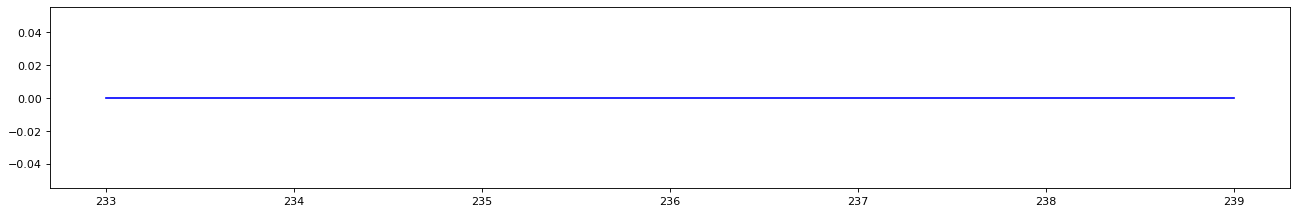

In [22]:
plt.figure(figsize=(20, 3), dpi=80)
sim.plot_fold()

2
0
0


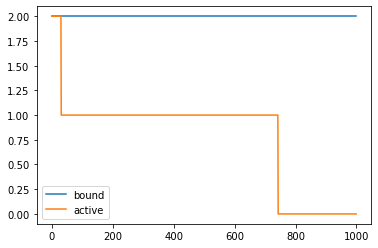

{'Cohesin': 38.0, 'Condensin': 1156.0}


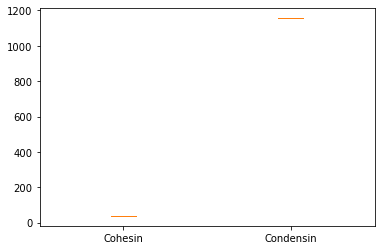

In [23]:
np.random.seed(27)
sim = Simulator(Genome(1),1, n_extruders=2, per_i=1, option="both_0.2")
sim.simulate(1000)
sim.plot()
print(sim.n_bound[-1])
print(sim.n_active[-1])
print(sum(sim.unbound))
plt.legend()
plt.show()
print(sim.average_domain())
plt.show()

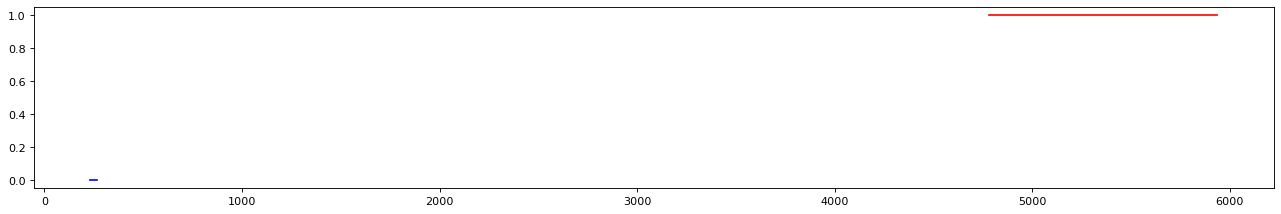

In [24]:
plt.figure(figsize=(20, 3), dpi=80)
sim.plot_fold()

In [25]:
np.where(sim.genome.occupited)

(array([ 230,  268, 4781, 5937]),)